In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import matplotlib.pyplot as plt

In [2]:
deg = np.pi/180.

## Setting up the model

$$
\cos (\Delta I) = \cos i_\mathrm{disk} \cos i_\star + \sin i_\mathrm{disk} \sin i_\star \cos(\Omega_\mathrm{disk} - \Omega_\star)
$$

The prior probability distributions are

$$
p(i_\mathrm{disk}, \Omega_\mathrm{disk}) = \frac{\sin i_\mathrm{disk}}{2} 
$$


In [88]:
# Define the likelihood by conditioning on the observations 
data = np.array([np.cos(33.5 * deg), 256.0 * deg, np.cos(33.42 * deg)])
    
# converting the uncertainty requires a change of variables 
# sigma_cos_i = sin(i) * sigma_i (where sigma_i is in radians)
sigma = np.array([ np.sin(33.5 * deg) * 1.4 * deg, 1.0 * deg, np.sin(33.42 * deg) * 0.01 * deg])

In [89]:
print(data)
print(sigma)

[ 0.83388582  4.46804289  0.83465566]
[  1.34863647e-02   1.74532925e-02   9.61278698e-05]


In [90]:
# instantiate a PyMC3 model class 
with pm.Model() as model:
    
    # priors on i_disk, Omega_disk, i_star, Omega_star
    # everything's assumed to be in radians
    # a uniform prior on cos(i) means p(i) = sin(i)
    cos_i_disk = pm.Uniform("cosIdisk", lower=-1.0, upper=1.0)
    Omega_disk = pm.Uniform("OmegaDisk", lower=0.0, upper=2*np.pi)
     
    cos_i_star = pm.Uniform("cosIstar", lower=-1.0, upper=1.0)
    Omega_star = pm.Uniform("OmegaStar", lower=0.0, upper=2*np.pi)
    
    # calculate the intermediate quantities for determining mutual inclination
    # to go from cos(i) -> sin(i), do 
    sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)
    sin_i_star = tt.sqrt(1.0 - cos_i_star**2)
        
    # store Delta I as a deterministic byproduct
    cos_Delta_I = pm.Deterministic("cosDeltaI", cos_i_disk * cos_i_star + \
                               sin_i_disk * sin_i_star * tt.cos(Omega_disk - Omega_star))

    # assemble a vector to compare to the observations
    mu = [cos_i_disk, Omega_disk, cos_i_star]
    obs = pm.Normal("obs", mu=mu, sd=sigma, observed=data)
    

In [91]:
model.free_RVs

[cosIdisk_interval__,
 OmegaDisk_interval__,
 cosIstar_interval__,
 OmegaStar_interval__]

In [92]:
model.deterministics

[cosIdisk, OmegaDisk, cosIstar, OmegaStar, cosDeltaI]

In [93]:
# We can test the model likelihood if we don't let PyMC3 automatically transform the variables
# transform=None in the prior definitions. 
# obs.logp({"cos_i_disk":0.833, "Omega_disk":4.46, "cos_i_star":0.83, "Omega_star":4.0})

In [94]:
# sample the model!
with model:
    trace = pm.sample(draws=1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [OmegaStar, cosIstar, OmegaDisk, cosIdisk]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:40<00:00, 147.54draws/s]


In [95]:
# visualize output
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
cosIdisk,0.834120,0.013583,0.000261,0.808601,0.861342,2924.189707,0.999686
OmegaDisk,4.468128,0.017666,0.000385,4.435456,4.504151,2286.171074,0.999529
cosIstar,0.834657,0.000099,0.000002,0.834466,0.834846,4014.435467,0.999903
OmegaStar,3.114126,1.775903,0.033767,0.093052,5.963027,2906.715939,0.999500
cosDeltaI,0.697439,0.218276,0.004182,0.391476,0.999970,2852.583455,0.999530


/home/ian/.build/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc16b1de80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcc1697e860>]], dtype=object)

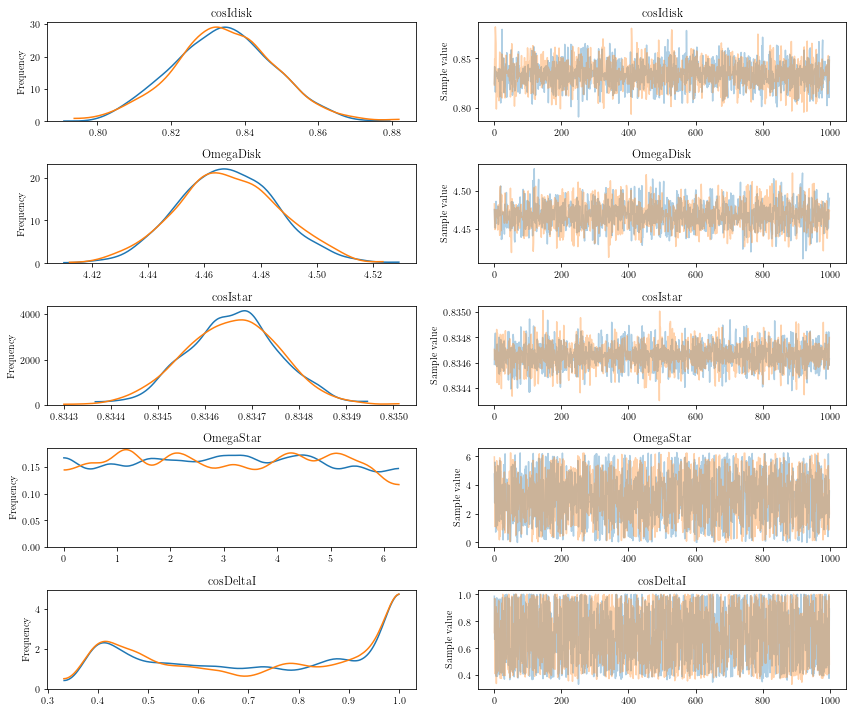

In [96]:
pm.traceplot(trace)

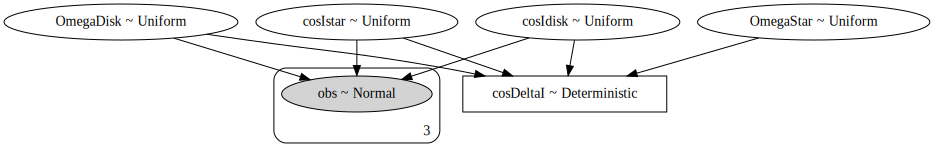

In [97]:
pm.model_to_graphviz(model)

In [98]:
# get the samples on cosDeltaI and map these into Delta I. Large cos(Delta I) values are actually small Delta I 
# values.

In [99]:
pm.__version__

'3.5'

In [100]:
import corner  

samples = pm.trace_to_dataframe(trace, varnames=["cosIdisk", "OmegaDisk", "cosIstar", "OmegaStar", "cosDeltaI"])
# convert to actual parameter space


# corner.corner(samples) #, truths=[true_m, true_b, true_logs]);

In [101]:
samples.head()

,cosIdisk,OmegaDisk,cosIstar,OmegaStar,cosDeltaI
0,0.824387,4.475185,0.834587,4.781975,0.985274
1,0.841648,4.461453,0.834722,2.766568,0.665736
2,0.829689,4.459497,0.834781,5.605622,0.819243
3,0.816034,4.450710,0.834833,3.194970,0.779851
4,0.837298,4.469946,0.834663,0.726948,0.450571


In [102]:
asamples = samples.copy()
asamples.rename(index=str, columns={"cosIdisk":"iDisk", "cosIstar":"iStar", "cosDeltaI":"deltaI"}, inplace=True);

In [103]:
asamples.head()

,iDisk,OmegaDisk,iStar,OmegaStar,deltaI
0,0.824387,4.475185,0.834587,4.781975,0.985274
1,0.841648,4.461453,0.834722,2.766568,0.665736
2,0.829689,4.459497,0.834781,5.605622,0.819243
3,0.816034,4.450710,0.834833,3.194970,0.779851
4,0.837298,4.469946,0.834663,0.726948,0.450571


In [104]:
icos2deg = lambda x: np.arccos(x)/deg

asamples["iDisk"] = asamples["iDisk"].apply(icos2deg)
asamples["OmegaDisk"] = asamples["OmegaDisk"] / deg
asamples["iStar"] = asamples["iStar"].apply(icos2deg)
asamples["OmegaStar"] = asamples["OmegaStar"] / deg
asamples["deltaI"] = asamples["deltaI"].apply(icos2deg)

In [105]:
asamples.head()

,iDisk,OmegaDisk,iStar,OmegaStar,deltaI
0,34.473583,256.409236,33.427193,273.986964,9.844900
1,32.685406,255.622424,33.413107,158.512656,48.261202
2,33.933202,255.510338,33.406996,321.178461,34.990928
3,35.310233,255.006918,33.401549,183.058278,38.753101
4,33.144075,256.109044,33.419249,41.651046,63.219701


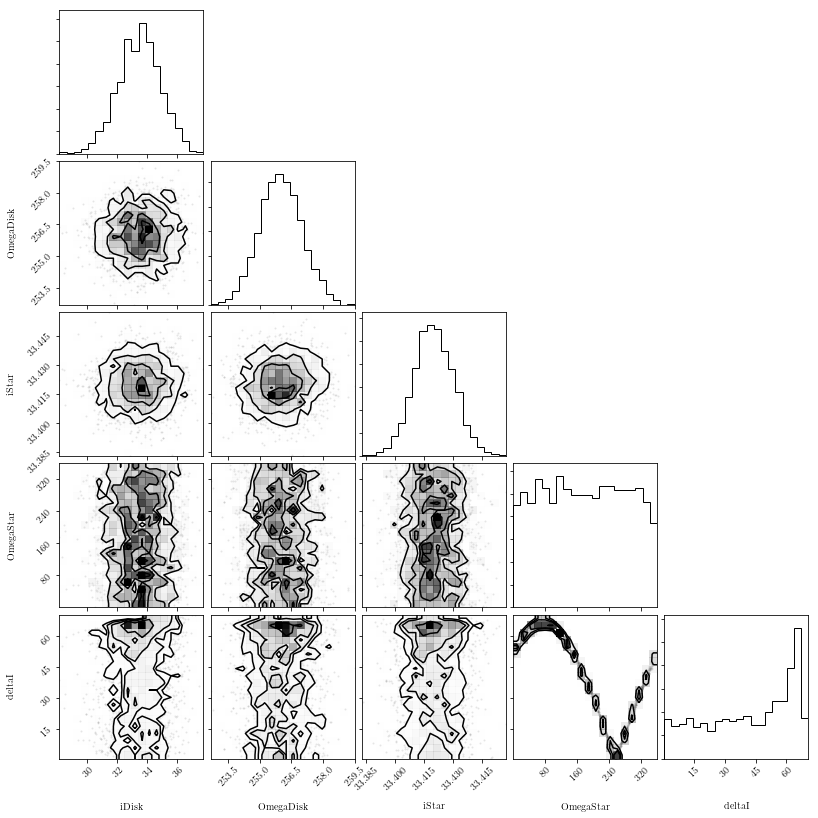

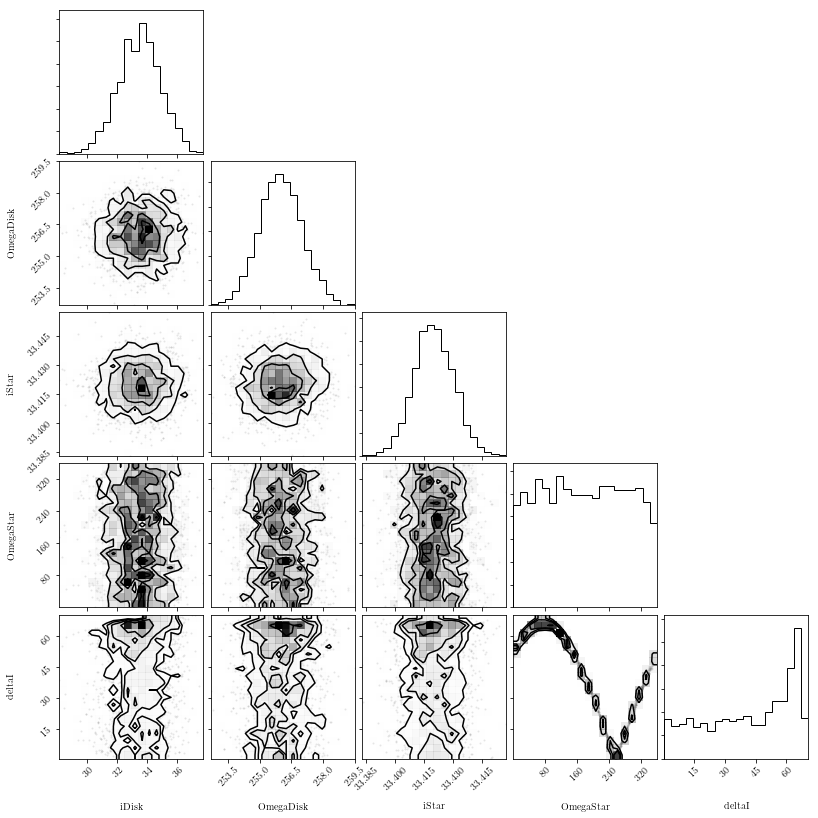

In [106]:
corner.corner(asamples) #, truths=[true_m, true_b, true_logs]);